# Finding Shapes
Christopher Fichtlscherer, 29.05.2020, fichtlscherer@mailbox.org

In [35]:
import numpy as np
import tensorflow as tf
from tqdm import tqdm
from tensorflow import keras
import matplotlib.pyplot as plt

from matplotlib import patches

import keras                                                                                       
from keras import Sequential                                                                       
from keras.models import Model                                                                     
from keras.callbacks import EarlyStopping                                                          
from keras.layers import Dense, Input, Convolution2D,MaxPooling2D,AveragePooling2D,Flatten,Dropout 
from keras import optimizers                                                                       

## Create Circle Data

In [64]:
def create_circle_array(x_size, y_size, center_x, center_y, thickness, radius):
    """creates a binary, two dim numpy array in which a circle has the
        value 1 all other values are 0"""

    x_mesh, y_mesh = np.mgrid[:x_size, :y_size]

    circle = (x_mesh - center_x) ** 2 + (y_mesh - center_y) ** 2

    c_array = np.logical_and(circle < (radius**2 + thickness), circle > (radius**2 - thickness)).astype(float)

    return c_array

In [88]:
n = 1000 # the number of arrays we want to create

split = 400 # till wich use the data for training
epos = 25

x_size, y_size = 100, 100 # size of the array
center_x, center_y = 50, 50 # center of the circle
delta_x, delta_y = 10, 10 # center will be random in [center_x - delta_x: center_x + delta_x]

thickness = 25 # thickness of the circle
radius = 15 # radius of the circle
delta_r = 0 # radius will be random in [radius - delta_r: radius + delta_r]

noise_level = 0

circles = np.zeros((n, x_size, y_size))
c_attributes = np.zeros((n, 3))

for i in tqdm(range(n)):
    
    cx = center_x + delta_x * (2 * (np.random.random()-0.5))
    cy = center_y + delta_y * (2 * (np.random.random()-0.5))
    r = radius + delta_r * (2 * (np.random.random()-0.5))

    attributes = np.array([cx, cy, r])
    c_array = create_circle_array(x_size, y_size, cx, cy, thickness, r)    

    circles[i] = c_array + noise_level * np.random.random((x_size, y_size))
    c_attributes[i] = attributes/100

100%|██████████| 1000/1000 [00:00<00:00, 2529.43it/s]


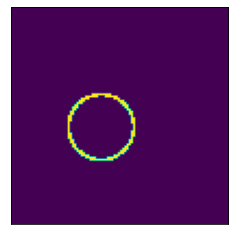

In [89]:
ax = plt.gca()
ax.imshow(circles[9])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

if False:
    p = 1

    Y = [30, 25, 70, 70]

    plt.scatter([Y[0]-p,Y[2]+p,Y[0]-p,Y[2]+p],\
                [Y[1]-p,Y[3]+p,Y[3]+p,Y[1]-p],c='red')
    ax.add_patch(patches.Rectangle((Y[0]-p,Y[1]-p),Y[2]-Y[0]+2*p,Y[3]-Y[1]+2*p,linewidth=2,edgecolor='r',facecolor='none'))


#plt.savefig("circle.png")

In [90]:
print(circles.shape)
print(c_attributes.shape)

circles_ex = np.expand_dims(circles, axis=3)

print(circles_ex.shape)

train_circles, test_circles = circles_ex[:split], circles_ex[split:]
train_attributes, test_attributes = c_attributes[:split], c_attributes[split:]

print(train_circles.shape)
print(train_attributes.shape)

(1000, 100, 100)
(1000, 3)
(1000, 100, 100, 1)
(400, 100, 100, 1)
(400, 3)


In [180]:
model = keras.Sequential([
    keras.layers.Conv2D(filters = 1, kernel_size = 30, input_shape=(x_size, y_size, 1)),
    keras.layers.Flatten(),
    keras.layers.Dense(3)
])

In [181]:
model.summary()

Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_78 (Conv2D)           (None, 71, 71, 1)         901       
_________________________________________________________________
flatten_37 (Flatten)         (None, 5041)              0         
_________________________________________________________________
dense_93 (Dense)             (None, 3)                 15126     
Total params: 16,027
Trainable params: 16,027
Non-trainable params: 0
_________________________________________________________________


In [182]:
model.compile(loss= "mean_squared_error" , optimizer="adam")
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=5)

In [183]:
model.fit(train_circles, train_attributes, epochs=epos, validation_split=0.1, shuffle=True, verbose=1, callbacks=[es])

Train on 360 samples, validate on 40 samples
Epoch 1/25
360/360 [==============================] - 10s 28ms/step - loss: 0.0832 - val_loss: 0.0425
Epoch 2/25
360/360 [==============================] - 9s 25ms/step - loss: 0.0297 - val_loss: 0.0330
Epoch 3/25
360/360 [==============================] - 9s 25ms/step - loss: 0.0145 - val_loss: 0.0194
Epoch 4/25
360/360 [==============================] - 9s 26ms/step - loss: 0.0069 - val_loss: 0.0158
Epoch 5/25
360/360 [==============================] - 9s 26ms/step - loss: 0.0041 - val_loss: 0.0156
Epoch 6/25
360/360 [==============================] - 9s 26ms/step - loss: 0.0032 - val_loss: 0.0152
Epoch 7/25
360/360 [==============================] - 9s 25ms/step - loss: 0.0020 - val_loss: 0.0135
Epoch 8/25
360/360 [==============================] - 9s 26ms/step - loss: 0.0015 - val_loss: 0.0138
Epoch 9/25
360/360 [==============================] - 9s 26ms/step - loss: 0.0013 - val_loss: 0.0137
Epoch 10/25
360/360 [========================

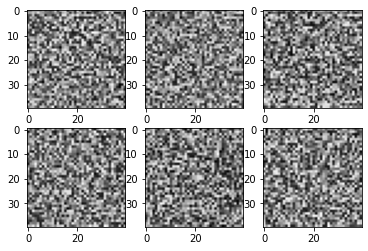

In [175]:
filters, biases = model.layers[0].get_weights()

f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

f0 = filters[:, :, :, 0]
f1 = filters[:, :, :, 1]
f2 = filters[:, :, :, 2]
f3 = filters[:, :, :, 3]
f4 = filters[:, :, :, 4]
f5 = filters[:, :, :, 5]

plt.subplot(231)
plt.imshow(f0[:, :, 0], cmap='gray')
plt.subplot(232)
plt.imshow(f1[:, :, 0], cmap='gray')
plt.subplot(233)
plt.imshow(f2[:, :, 0], cmap='gray')
plt.subplot(234)
plt.imshow(f3[:, :, 0], cmap='gray')
plt.subplot(235)
plt.imshow(f4[:, :, 0], cmap='gray')
plt.subplot(236)
plt.imshow(f5[:, :, 0], cmap='gray')


plt.savefig("filters.png")

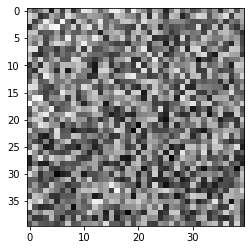

In [122]:
filters, biases = model.layers[0].get_weights()

f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

f0 = filters[:, :, :, 0]
plt.imshow(f0[:, :, 0], cmap='gray')

In [13]:
model.evaluate(test_circles, test_attributes)

200/200 [==============================] - 1s 6ms/sample - loss: 5.8139


5.813899250030517

In [14]:
predictions = model.predict(test_circles)

for i in range(30):
    print(max(abs(predictions[i]- test_attributes[i])))

3.743887869947052
3.5569531661994915
5.7039953238009105
4.4366862394758755
4.612446178806152
2.762293694036998
1.4636638537526352
3.8740239419732134
3.1991386078757884
6.258245107541782
2.7506211128313396
2.4297295304153437
2.638322862781017
2.548914299556415
2.255117583128907
5.298943225598094
2.7141520153679863
0.3328087734209717
0.7956380635508324
0.8333701152728921
2.2907650179416024
1.0084003518757
2.0988237767575235
3.626166667420094
4.740705569674958
2.208199842377283
4.589606294732576
2.1734210389005852
1.3125367422712095
3.937106662866313


***

### Plot a box around the Circle

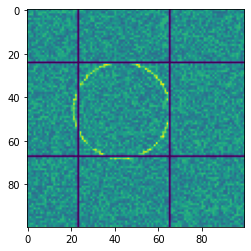

In [23]:
circle_number = 6

cx, cy, r = predictions[circle_number]

x_1 = int(cx - r)
x_2 = int(cx + r)

y_1 = int(cy - r)
y_2 = int(cy + r)

test_circle_2d = test_circles[circle_number,:,:,0]

w_image = test_circle_2d.copy()
w_image[:,y_1] = -1
w_image[:,y_2] = -1
w_image[x_1-1 : x_1] = -1
w_image[x_2-1 : x_2] = -1

plt.imshow(w_image)

plt.savefig("example.png")

## Create Rectangular Data

In [17]:
def create_rect_array(x_size, y_size, left, right, top, bottom, thickness):
    """creates a binary, two dim numpy array in which a circle has the
        value 1 all other values are 0"""

    rect = np.zeros((x_size, y_size))

    rect[left-thickness:right+thickness, bottom-thickness:top+thickness] = 1
    rect[left:right, bottom:top] = 0
    
    return rect

In [24]:
n = 500 # the number of arrays we want to create

split = 400 # till wich use the data for training
epos = 20

x_size, y_size = 100, 100 # size of the array
left, right = 30, 60 
delta_left, delta_right = 15, 15 

bottom, top = 30, 60 # center of the circle
delta_bottom, delta_top = 15, 15 

thickness = 3 

noise_level = 0.5

rectangles = np.zeros((n, x_size, y_size))
r_attributes = np.zeros((n, 4))

for i in tqdm(range(n)):
    
    l = int(left + delta_left * (2 * (np.random.random()-0.5)))
    r = int(right + delta_right * (2 * (np.random.random()-0.5)))
    
    t = int(top + delta_top * (2 * (np.random.random()-0.5)))
    b = int(bottom + delta_bottom * (2 * (np.random.random()-0.5)))
    
    
    attributes = np.array([l, r, t, b])
    rect = create_rect_array(x_size, y_size, l, r, t, b, thickness)

    rectangles[i] = rect + noise_level * np.random.random((x_size, y_size))
    r_attributes[i] = attributes

100%|██████████| 500/500 [00:00<00:00, 4480.28it/s]


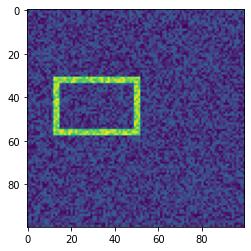

In [25]:
plt.imshow(rectangles[9])

In [26]:
rectangles_ex = np.expand_dims(rectangles, axis=3)

train_rectangles, test_rectangles = rectangles_ex[:split], rectangles_ex[split:]
train_attributes, test_attributes = r_attributes[:split], r_attributes[split:]

In [27]:
model = keras.Sequential([
    keras.layers.Conv2D(filters = 6, kernel_size = 65, input_shape=(x_size, y_size, 1)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(4)
])

In [28]:
model.compile(loss= "mean_squared_error" , optimizer="adam")

In [29]:
model.fit(train_rectangles, train_attributes, epochs=epos)

Epoch 1/20
400/400 [==============================] - 11s 27ms/sample - loss: 971.4330
Epoch 2/20
400/400 [==============================] - 11s 28ms/sample - loss: 153.7092
Epoch 3/20
400/400 [==============================] - 12s 30ms/sample - loss: 89.9782
Epoch 4/20
400/400 [==============================] - 11s 27ms/sample - loss: 66.8269
Epoch 5/20
400/400 [==============================] - 11s 28ms/sample - loss: 59.0628
Epoch 6/20
400/400 [==============================] - 12s 29ms/sample - loss: 60.0183
Epoch 7/20
400/400 [==============================] - 10s 26ms/sample - loss: 55.4091
Epoch 8/20
400/400 [==============================] - 11s 28ms/sample - loss: 49.3131
Epoch 9/20
400/400 [==============================] - 12s 30ms/sample - loss: 42.0198
Epoch 10/20
400/400 [==============================] - 12s 29ms/sample - loss: 33.6791
Epoch 11/20
400/400 [==============================] - 12s 30ms/sample - loss: 24.9155
Epoch 12/20
400/400 [=============================

In [30]:
model.evaluate(test_rectangles, test_attributes)

100/100 [==============================] - 1s 7ms/sample - loss: 4.4570


4.457036991119384

In [31]:
predictions = model.predict(test_rectangles)

In [53]:
rect_number = 1

l, r, t, b = predictions[rect_number]

test_rect_2d = test_rectangles[rect_number,:,:,0]

w_image = test_rect_2d.copy()
w_image[:,int(b)] = -1
w_image[:,int(t)] = -1
w_image[int(l)-1 : int(l)] = -1
w_image[int(r)-1 : int(r)] = -1

plt.imshow(w_image)

IndexError: index 103 is out of bounds for axis 1 with size 100